In [1]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
import numpy as np
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors

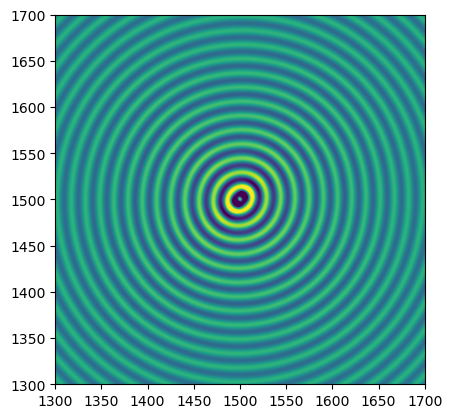

In [155]:
M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
vmax = np.max(np.abs(M_oop))*0.3
plt.imshow(np.real(M_oop),vmin=-vmax,vmax=vmax)
mid = 1500
range = 200
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)
plt.show()

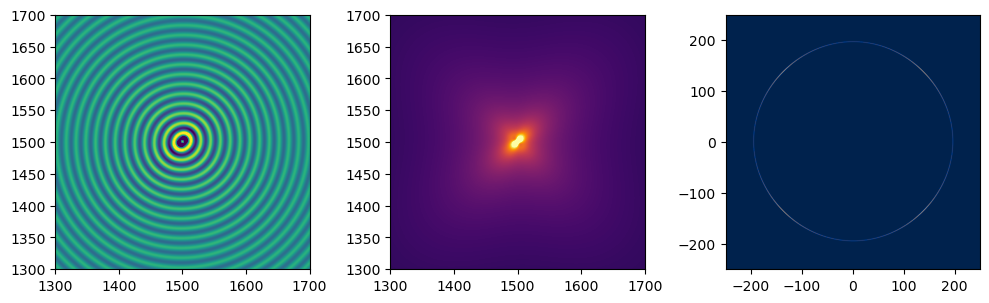

In [199]:
M_kq = np.fft.fft2(M_oop)
M_kq = np.fft.fftshift(M_kq)
kLen = int(M_kq.shape[1] / 2)
# zeros = np.zeros((M_kq.shape[0], kLen))
# M_kq[:, :kLen] = zeros
# M_yx_filtered = np.fft.ifft2(M_kq)
# M_yx_filtered /= np.amax(
#     np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
# )
# point_source = M_yx_filtered[:,int(M_oop.shape[1] / 2):]
# fft_point_source_filtered = np.fft.fft2(point_source)
# fft_point_source_filtered = np.fft.fftshift(fft_point_source_filtered)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(np.real(M_oop),vmin=-vmax,vmax=vmax)
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)

plt.subplot(132)
plt.imshow(np.abs(M_oop),vmin=0,vmax=.1, cmap='inferno')
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)

plt.subplot(133)
plt.imshow(np.abs(M_kq)**4, cmap='cividis',extent=[kLen,-kLen,kLen,-kLen])
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.tight_layout()
plt.show()

In [ ]:
NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def calculate_analytic_signal(npz):
    loaded = np.load(file=npz, allow_pickle=True)    
    arr = loaded["arr"][:,:,0]
    arr /= np.amax(arr)
    metadata = loaded["metadata"].item()    
    dx = metadata["dx"]    
    dy = metadata["dy"]    
    tb = metadata["talbot_length"] 
    g_in_an = arr[0]
    return dx, dy, g_in_an, tb

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def normalize_and_slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16,
    axhl: int,
    offset: int,
    unit_cell_size: int,
) -> NP2DF8:
    # newField2 = np.abs(np.real(newField[:,:])+np.imag(newField[:,:]))
    # newField2 = np.real(newField) ** 2 + np.imag(newField) ** 2
    newField2 = np.abs(newField)
    newField2 = newField2[
        int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), :
    ]
    return newField2

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def logic_oop_test(
    unit_cell_size: int,  # nm
    offset: int,
    npz: str,
    plots: bool = True,
    one_d_phase: bool = False,
):
    
    talbot_length = calculate_analytic_signal(npz)[3]*unit_cell_size
    
    input_output_distance = talbot_length / 2
    axhl = int(input_output_distance // unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()
    g_in_c: NP1DC16 = calculate_analytic_signal(npz)[2]
    newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
    intensity: NP2DF8 = normalize_and_slice_field(
        newField, pointSrc, axhl, offset, unit_cell_size)
    
    if plots:

        intensity_1d_x = np.arange(0, intensity.shape[0], 1)
        loaded = np.load(file=npz, allow_pickle=True)    
        arr = loaded["arr"][:,:,0]
        arr /= np.amax(arr)
        metadata = loaded["metadata"].item()    
        dx = metadata["dx"]    
        dy = metadata["dy"]    
        tb = metadata["talbot_length"]    
        # n = metadata["number_of_inputs"]    
        # d = metadata["distance_between_inputs"]  
        hline_y = np.argmin(np.abs(np.arange(arr.shape[1]) * dy - tb))
        y_mumax1D = arr[hline_y]    
        # y_mumax1D /= np.amax(y_mumax1D)
        x_mumax1D = np.arange(y_mumax1D.shape[0]) * dx * 1e9    
        x_int = np.arange(0, intensity.shape[0]+1, 1)

        f, ax = plt.subplots(4,1, sharex=True, height_ratios=[1.5, 2, 2, 0.5], figsize=(8, 10))

        ax[3].plot(x_int*unit_cell_size, np.abs(g_in_c), color='k')
        ax[3].fill_between(x_int*unit_cell_size, 0, np.abs(g_in_c), color='#CCCCCC')
        ax[3].set_ylim(-0.1, 1.1)
        ax[3].set_ylabel("Amplitude")
        ax0a = ax[3].twinx()
        ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='y', labelcolor='maroon')
        ax0a.set_ylabel("Phase (°)", color='maroon')
        ax0a.set_ylim(-190, 190)
        ax0a.set_yticks(range(-180, 190, 90))
        
        ax[2].set_title("HFPBC")
        ax[2].imshow(np.rot90(intensity), aspect='auto', 
                     extent=[0, unit_cell_size * intensity.shape[0], 0, unit_cell_size * intensity.shape[1]]
                     )
        ax[2].axhline(tb*1e9, color='blue', lw=3, alpha=1)
        ax[2].set_xlabel("x (nm)")
        ax[2].set_ylabel("y (nm)")
        # ax[2].set_xlim(0, dx*arr.shape[0])
        ax[2].set_ylim(0, tb*1e9+offset)

        ax[1].set_title("Mumax")
        ax[1].imshow(arr, aspect="auto", 
                     extent=[0, dx * arr.shape[1]*1e09 , 0, dy * arr.shape[0]*1e09], 
                    origin="lower"
                     )    
        ax[1].axhline(tb*1e9 , color="red", lw=3)    
        ax[1].set_xlabel("x (nm)")    
        ax[1].set_ylabel("y (nm)")  

        intensity[:, axhl] /= np.amax(intensity[:, axhl])
        ax[0].plot(intensity_1d_x*unit_cell_size, intensity[:, axhl], linewidth=3, color='blue', label='hfpbc')
        ax[0].set_ylabel("Amplitude")
        y_mumax1D /= np.amax(y_mumax1D)
        ax[0].plot(x_mumax1D, y_mumax1D, color='red', lw=3, label='mumax')
        ax[0].legend()

        plt.tight_layout()
        plt.show()

In [6]:
def display_metadata(npz_path):
    loaded = np.load(file=npz_path, allow_pickle=True)
    metadata = loaded["metadata"].item()
    
    metadata_str = "\n".join([f"{key}: {value}" for key, value in metadata.items()])
    print(metadata_str)

display_metadata("mumax_data/new_intensities/001111100_0_0_0_0_0.5_0_0.5_0_0.npz")

Aex: 3.5e-12
AutoMeshx: True
AutoMeshy: True
B_ext: 0xc0002232f0
MaxDt: 1e-13
MaxErr: 1e-08
Msat: 140000
Nx: 700
Ny: 486
Nz: 1
PBCx: 1
PBCy: 1
PBCz: 0
Tx: 1.0725e-05
Ty: 7.425646551724137e-06
Tz: 5e-08
a1: 0
a2: 0
a3: 1
a4: 1
a5: 1
a6: 1
a7: 1
a8: 0
a9: 0
absorbing_cells: 200
alpha_max: 1
alpha_mid_pos: 0.3
alpha_min: 0
alpha_region_index_offset: 50
alpha_slope: 3
alpha_step_count: 100
alpha_step_size: 2
amps: 0.001
distance_between_inputs: 5.25e-07
distance_between_inputs_cells: 34
dx: 1.5321428571428572e-08
dy: 1.5277777777777775e-08
dz: 5e-08
end_time: Tue Nov 12 15:03:09 CET 2024
f: 2600000000
gpu: NVIDIA GeForce RTX 3080 Ti(11937MB), CUDA Driver 12.6, cc=8.6
input_width: 2.4e-07
input_width_cells: 16
mask: [0xc00027c000 0xc0003ca000 0xc000790000] [700 486 1] 1
number_of_inputs: 9
p1: 0
p2: 0
p3: 0
p4: 0
p5: 0.5
p6: 0
p7: 0.5
p8: 0
p9: 0
port: 35367
spin_wave_speed: 603.2
start_time: 2024-11-12T15:01:41.508900849+01:00
steps: 35648
t_sampl: 3.846153846153846e-11
talbot_length: 1.18

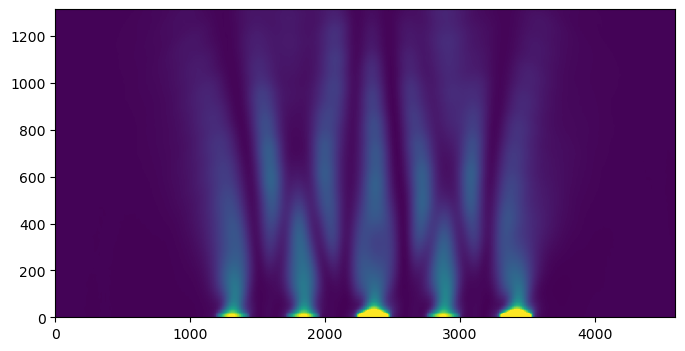

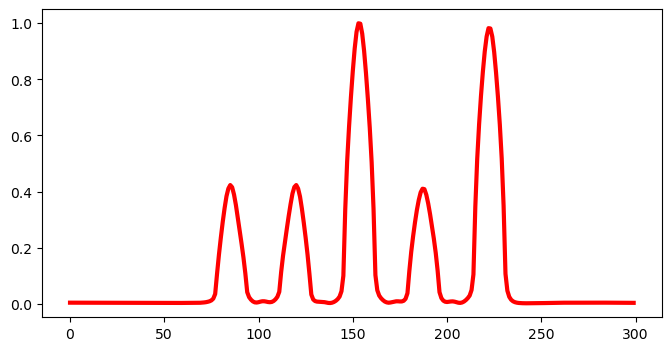

In [268]:
loaded = np.load(file='mumax_data/new_intensities/001111100_0_0_0_0_0.5_0_0.5_0_0.npz', allow_pickle=True)    
arr = loaded["arr"][:,:,0]**2
arr /= np.amax(arr)
metadata = loaded["metadata"].item()    
dx = metadata["dx"]    
dy = metadata["dy"]    
tb = metadata["talbot_length"] 
plt.figure(figsize=(8, 4))
plt.imshow(arr, aspect="auto", extent=[0, dx * arr.shape[1] * 1e9, 0, dy * arr.shape[0]*1e09], origin="lower",
                vmin=0, vmax=0.4
                )
hline_y = np.argmin(np.abs(np.arange(arr.shape[1]) * dy - tb))
plt.figure(figsize=(8, 4))
plt.plot(arr[0], color='red', lw=3)
plt.show()

In [ ]:
def logic_oop_test(
    unit_cell_size: int,  # nm
    offset: int,
    npz: str,
    plots: bool = True,
    one_d_phase: bool = False,
):

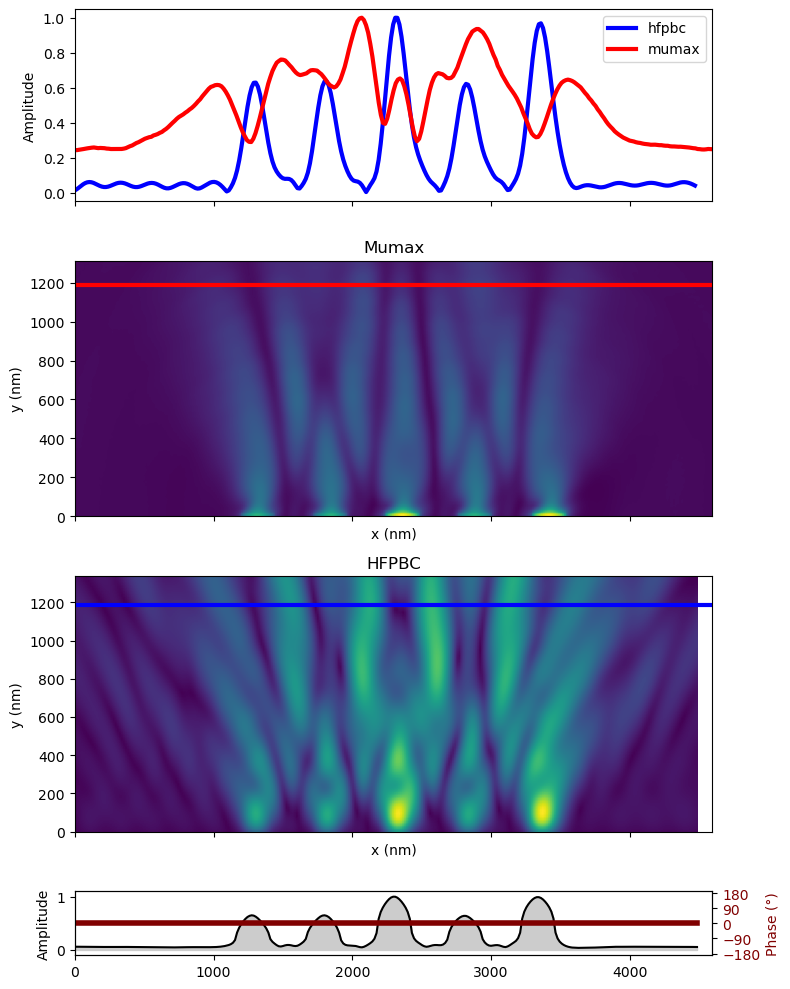

In [385]:
if __name__ == "__main__":
    tt = logic_oop_test(
        unit_cell_size=15,  # nm
        offset=150,  # nm
        npz = "mumax_data/new_intensities/001111100_0_0_0_0_0.5_0_0.5_0_0.npz",
        plots=True,
        one_d_phase=False
    )

### DENSER

In [67]:
M_oop_denser = np.load("./point_source_yig/m_final.npz")["arr_0"]

In [68]:
# M_oop_denser = np.load("./point_source_yig/pt_src.npy")
M_oop_denser_mx = M_oop_denser[0,:,:,2]
M_oop_denser_my = M_oop_denser[0,:,:,1]
M_oop_denser_mz = M_oop_denser[0,:,:,0]

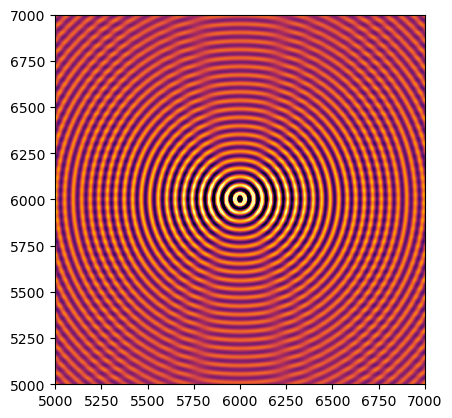

In [77]:
plt.imshow(M_oop_denser_my, cmap='inferno',vmin=-0.005, vmax=0.005, interpolation='none')
plt.xlim(5000,7000)
plt.ylim(5000,7000)
plt.show()

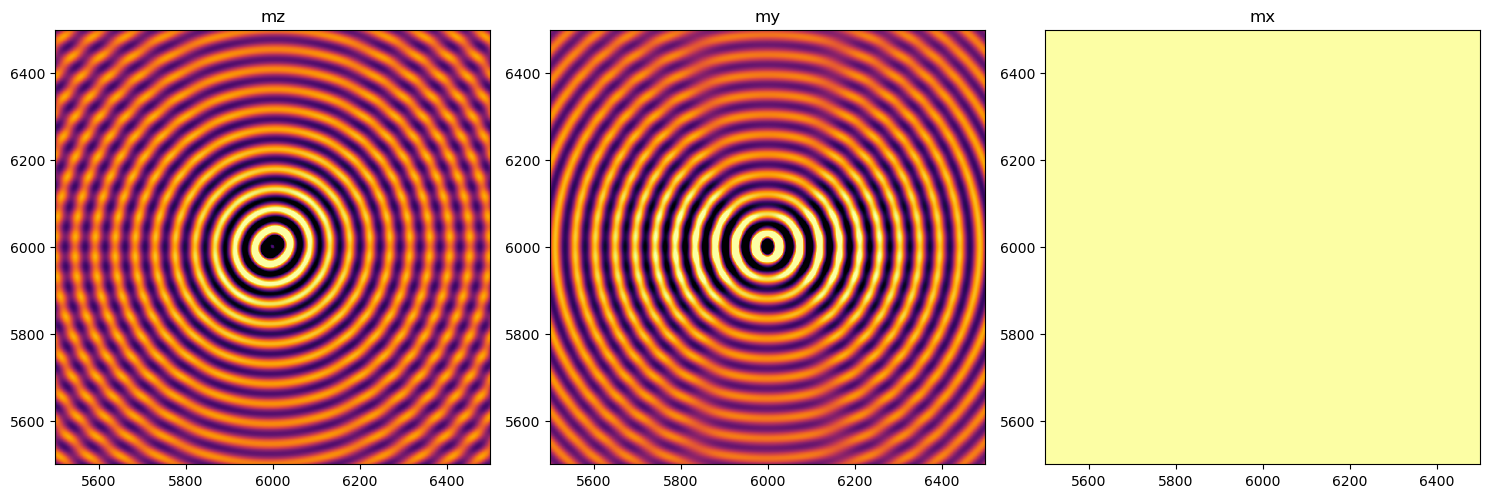

In [92]:
mid = 6000
range = 500

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title("mz")
plt.imshow(M_oop_denser_mz, cmap='inferno', interpolation='none',vmin=-0.005, vmax=0.005)
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)

plt.subplot(132)
plt.title("my")
plt.imshow(M_oop_denser_my, cmap='inferno', interpolation='none',vmin=-0.005, vmax=0.005)
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)

plt.subplot(133)
plt.title("mx")
plt.imshow(M_oop_denser_mx, cmap='inferno',interpolation='none',vmin=-1, vmax=1)
plt.xlim(mid-range,mid+range)
plt.ylim(mid-range,mid+range)

plt.tight_layout()
plt.show()

In [78]:
M_kq_denser_mx = np.fft.fft2(M_oop_denser_mx)
M_kq_denser_mx = np.fft.fftshift(M_kq_denser_mx)
kLen_mx = int(M_kq_denser_mx.shape[1] / 2)

M_kq_denser_my = np.fft.fft2(M_oop_denser_my)
M_kq_denser_my = np.fft.fftshift(M_kq_denser_my)
kLen_my = int(M_kq_denser_my.shape[1] / 2)

M_kq_denser_mz = np.fft.fft2(M_oop_denser_mz)
M_kq_denser_mz = np.fft.fftshift(M_kq_denser_mz)
kLen_mz = int(M_kq_denser_mz.shape[1] / 2)

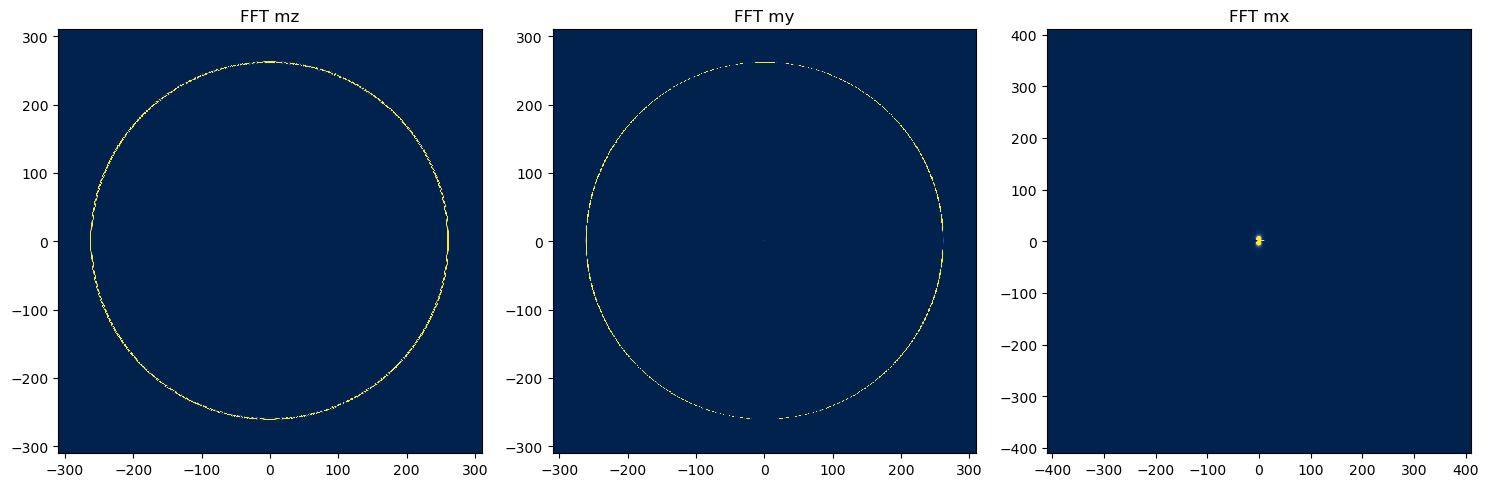

In [101]:
range = 310
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("FFT mz")
plt.imshow(np.abs(M_kq_denser_mz)**4, cmap='cividis', extent=[kLen_mz,-kLen_mz,kLen_mz,-kLen_mz], interpolation='none',vmax=1e12)
plt.xlim(-range,range)
plt.ylim(-range,range)

plt.subplot(132)
plt.title("FFT my")
plt.imshow(np.abs(M_kq_denser_my)**4, cmap='cividis', extent=[kLen_my,-kLen_my,kLen_my,-kLen_my], interpolation='none',vmax=1e12)
plt.xlim(-range,range)
plt.ylim(-range,range)

plt.subplot(133)
plt.title("FFT mx")
plt.imshow(np.abs(M_kq_denser_mx)**4, cmap='cividis', extent=[kLen_mx,-kLen_mx,kLen_mx,-kLen_mx],vmax=100, interpolation='none')
plt.xlim(-range-100,range+100)
plt.ylim(-range-100,range+100)

plt.tight_layout()
plt.show()